In [139]:
import pandas as pd
import numpy as np
import spacy

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [140]:
from datasets import load_dataset

dataset = load_dataset("shahxeebhassan/human_vs_ai_sentences")

for k in dataset.keys():
    dataset[k].to_csv(f'../data/{k}_human_vs_ai_sentences.csv', index = False)

Creating CSV from Arrow format: 100%|██████████| 105/105 [00:00<00:00, 211.34ba/s]


In [141]:
df = pd.read_csv("../data/train_human_vs_ai_sentences.csv")
df.head(5)

,text,label
0,Another reason why all students should have to...,0
1,Also the Electoral College consists of 538 ele...,0
2,Many countries have made changes in there town...,0
3,I believe the process of choosing a president ...,0
4,A thick cloud of carbon dioxide and heats to h...,0


In [142]:
print(f"Human texts: {(df['label'] == 0).sum()}")

print(f"AI texts: {(df['label'] == 1).sum()}")

Human texts: 52500
AI texts: 52500


## Analysis

In [143]:
#Sample
df = df.sample(10000, random_state=0)

In [164]:
nlp = spacy.load("en_core_web_sm")

rows = []

for _, row in df.iterrows():
    doc = nlp(row.text)

    rows.append({
        "vector": doc.vector,
        "symbol_count": len(row.text),
        "token_count": len(doc),
        "token_len": len(row.text)/len(doc),
        "sentence_count": len(list(doc.sents)),
        "unique_tokens_count": len(set([t.text for t in doc if not t.is_punct])),
        "unique_token_ratio": len(set([t.text for t in doc if not t.is_punct])) / len(doc),
        "stop_word_ratio": len([t for t in doc if t.is_stop]) / len(doc),
        "comma_density": row.text.count(',') / max(len(row.text), 1) * 1000,
        "period_density": row.text.count('.') / max(len(row.text), 1) * 1000
    })

f_df = pd.DataFrame(rows)
f_df = pd.concat([df['label'].reset_index(drop=True), f_df.reset_index(drop=True)], axis=1)

label_map = {0: "Human", 1: "AI"}
f_df["label_text"] = f_df["label"].map(label_map)

smf_df = f_df[f_df["symbol_count"] <= 250]

In [165]:
f_df

,label,vector,symbol_count,token_count,token_len,sentence_count,unique_tokens_count,unique_token_ratio,stop_word_ratio,comma_density,period_density,label_text
0,1,"[-0.37548882, -0.27621207, -0.10975007, -0.134...",71,14,5.071429,1,12,0.857143,0.500000,0.000000,14.084507,AI
1,0,"[-0.2696849, -0.13236189, 0.08262889, -0.01146...",178,36,4.944444,1,23,0.638889,0.416667,16.853933,5.617978,Human
2,1,"[0.009406307, -0.32786164, 0.051851757, -0.101...",183,33,5.545455,1,26,0.787879,0.575758,5.464481,5.464481,AI
3,0,"[0.2291652, 0.4451469, -0.24918771, -1.2330818...",18,3,6.000000,1,2,0.666667,0.000000,0.000000,55.555556,Human
4,1,"[-0.28644896, -0.39041477, 0.40360314, -0.1074...",43,13,3.307692,1,10,0.769231,0.461538,46.511628,0.000000,AI
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,"[0.19264492, -0.2870953, 0.15072444, 0.1264851...",102,23,4.434783,1,18,0.782609,0.478261,9.803922,0.000000,AI
9996,1,"[-0.25524887, -0.4190306, 0.25458327, -0.14346...",69,17,4.058824,1,16,0.941176,0.647059,0.000000,14.492754,AI
9997,0,"[-0.43663687, -0.48110798, 0.5521626, -0.01338...",250,61,4.098361,1,34,0.557377,0.754098,4.000000,4.000000,Human
9998,0,"[-0.30400282, 0.0024729446, -0.1280509, -0.048...",51,12,4.250000,1,9,0.750000,0.416667,39.215686,19.607843,Human


In [166]:
f_df.columns

Index(['label', 'vector', 'symbol_count', 'token_count', 'token_len',
       'sentence_count', 'unique_tokens_count', 'unique_token_ratio',
       'stop_word_ratio', 'comma_density', 'period_density', 'label_text'],
      dtype='object')

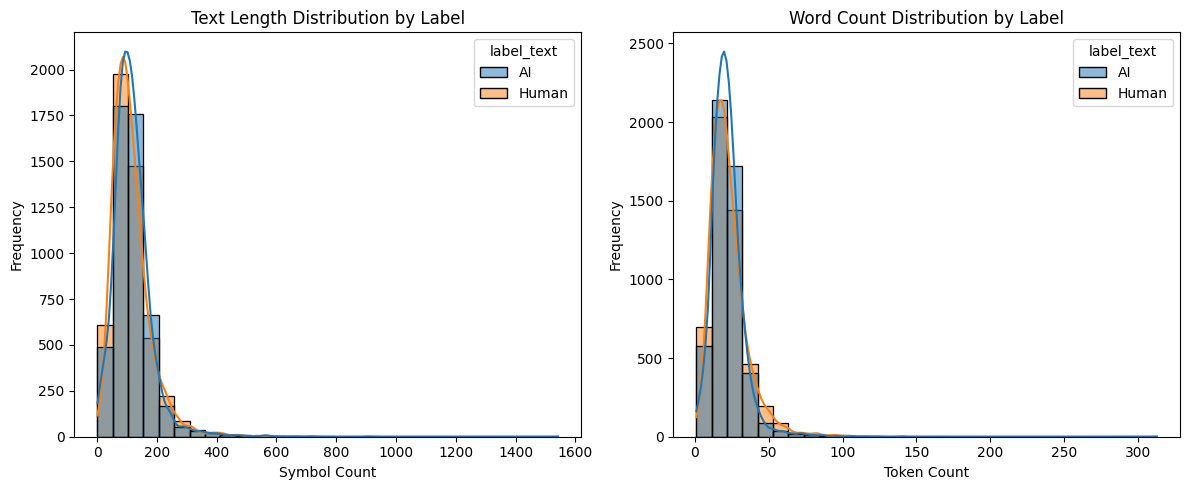

In [ ]:


plt.figure(figsize=(12, 5))

# Text length distribution by label
plt.subplot(1, 2, 1)
sns.histplot(data=f_df, x='symbol_count', hue='label_text', bins=30, kde=True)
plt.xlabel('Symbol Count')
plt.ylabel('Frequency')

# Word count distribution by label
plt.subplot(1, 2, 2)
sns.histplot(data=f_df, x='token_count', hue='label_text', bins=30, kde=True)
plt.xlabel('Token Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


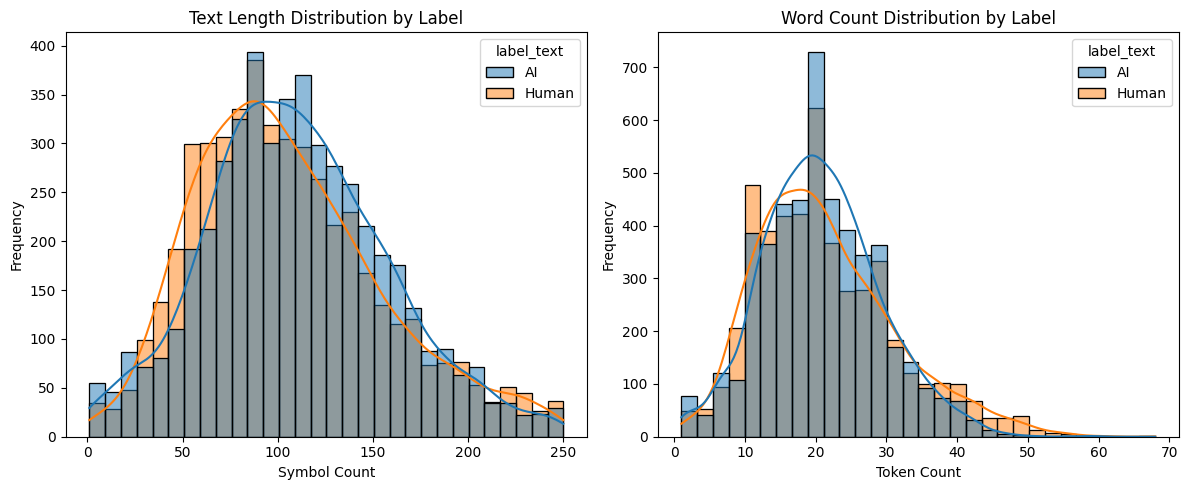

In [ ]:
plt.figure(figsize=(12, 5))

# Text length distribution by label
plt.subplot(1, 2, 1)
sns.histplot(data=smf_df, x='symbol_count', hue='label_text', bins=30, kde=True)
plt.xlabel('Symbol Count')
plt.ylabel('Frequency')

# Word count distribution by label
plt.subplot(1, 2, 2)
sns.histplot(data=smf_df, x='token_count', hue='label_text', bins=30, kde=True)
plt.xlabel('Token Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


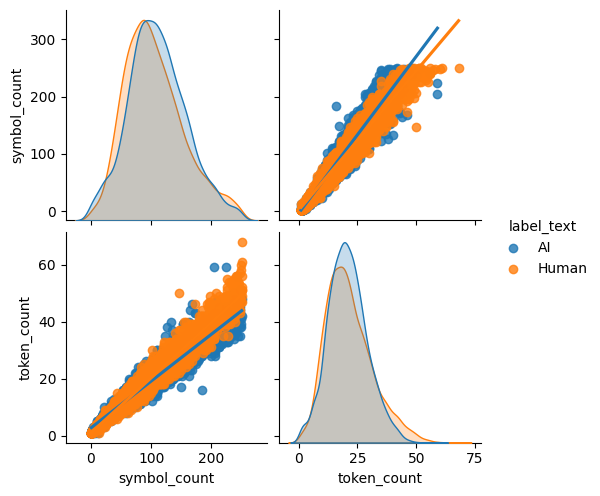

In [171]:
sns.pairplot(smf_df.drop('vector', axis=1), hue='label_text', kind='reg', vars=['symbol_count', 'token_count'])

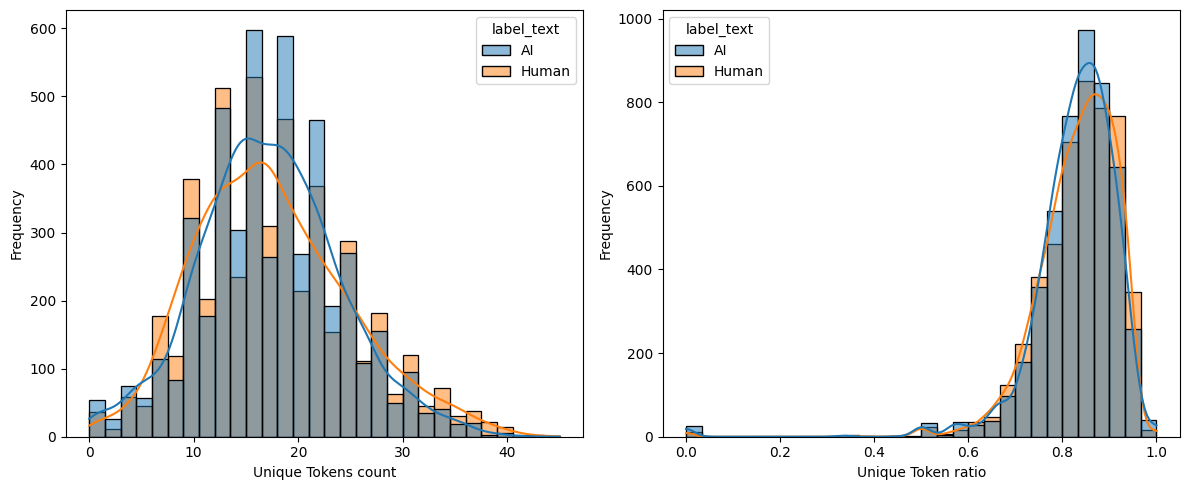

In [174]:
plt.figure(figsize=(12, 5))

# Text length distribution by label
plt.subplot(1, 2, 1)
sns.histplot(data=smf_df, x='unique_tokens_count', hue='label_text', bins=30, kde=True)
plt.xlabel('Unique Tokens count')
plt.ylabel('Frequency')

# Word count distribution by label
plt.subplot(1, 2, 2)
sns.histplot(data=smf_df, x='unique_token_ratio', hue='label_text', bins=30, kde=True)
plt.xlabel('Unique Token ratio')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


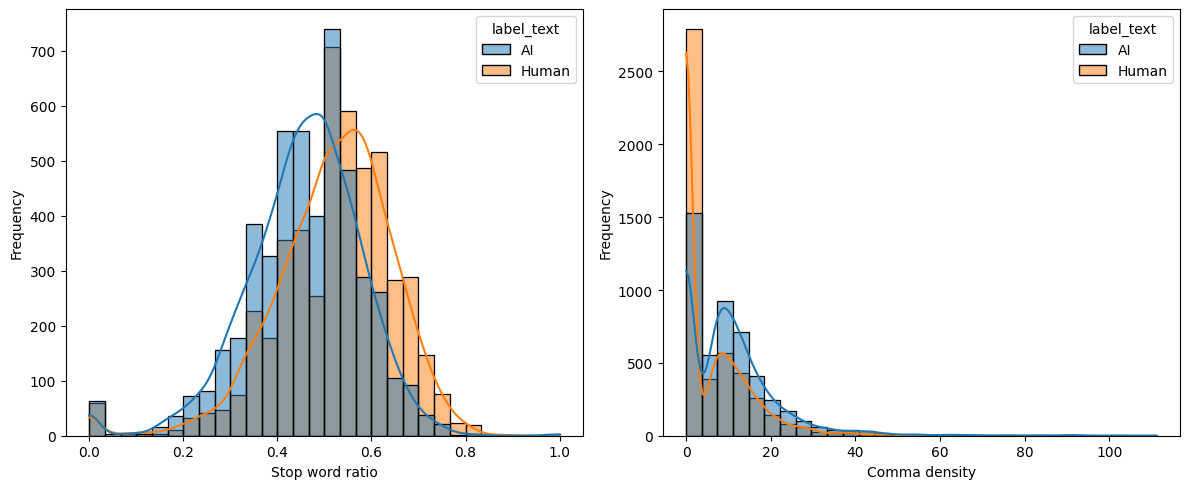

In [176]:
plt.figure(figsize=(12, 5))

# Text length distribution by label
plt.subplot(1, 2, 1)
sns.histplot(data=smf_df, x='stop_word_ratio', hue='label_text', bins=30, kde=True)
plt.xlabel('Stop word ratio')
plt.ylabel('Frequency')

# Word count distribution by label
plt.subplot(1, 2, 2)
sns.histplot(data=smf_df, x='comma_density', hue='label_text', bins=30, kde=True)
plt.xlabel('Comma density')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


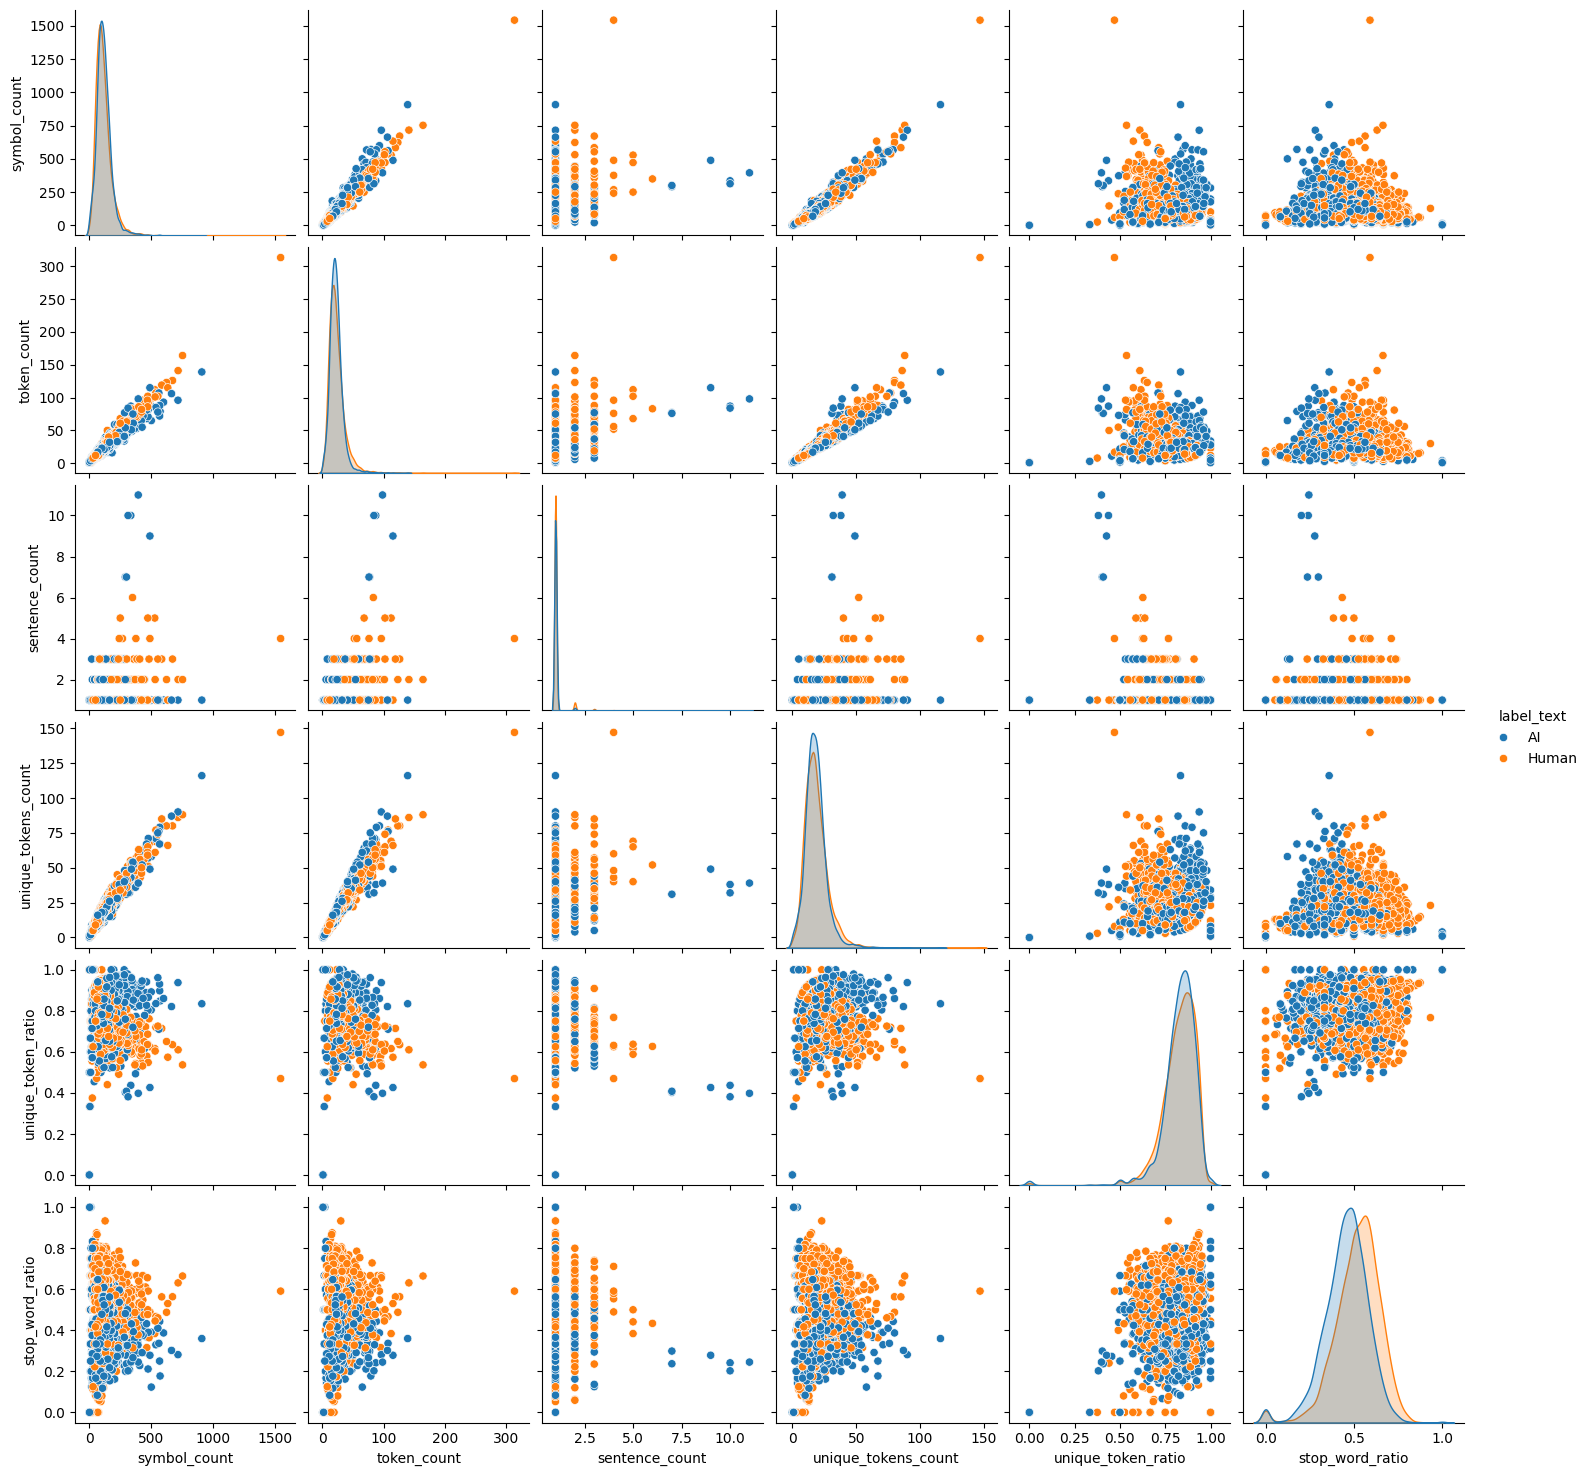

In [170]:
g = sns.pairplot(f_df.drop('vector', axis=1), hue='label_text', vars=['symbol_count', 'token_count', 'sentence_count', 'unique_tokens_count', 
                                                             'unique_token_ratio', 'stop_word_ratio'])

# Classifying

In [197]:
x = np.vstack(f_df['vector'].values)
y = f_df['label'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

model = Sequential([
    Dense(96, activation='relu'),
    Dense(92, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=500, epochs=100, validation_split=0.2)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6355 - loss: 0.6699 - val_accuracy: 0.6844 - val_loss: 0.6362
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6981 - loss: 0.6027 - val_accuracy: 0.7106 - val_loss: 0.5688
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7295 - loss: 0.5492 - val_accuracy: 0.7163 - val_loss: 0.5454
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7411 - loss: 0.5249 - val_accuracy: 0.7319 - val_loss: 0.5311
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7569 - loss: 0.4989 - val_accuracy: 0.7425 - val_loss: 0.5173
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7705 - loss: 0.4820 - val_accuracy: 0.7556 - val_loss: 0.5079
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7833 - loss: 0.4641 - val_accuracy: 0.7513 - val_loss: 0.5207
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7866 - loss: 0.4512 - val_accuracy: 0.7575 - 

In [198]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7245 - loss: 2.1568
Test Accuracy: 0.7245


In [199]:
model = Sequential([
    Dense(96, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=500, epochs=100, validation_split=0.2)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6152 - loss: 0.6685 - val_accuracy: 0.6994 - val_loss: 0.6332
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6848 - loss: 0.6174 - val_accuracy: 0.7100 - val_loss: 0.5833
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7144 - loss: 0.5740 - val_accuracy: 0.7256 - val_loss: 0.5523
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7356 - loss: 0.5427 - val_accuracy: 0.7237 - val_loss: 0.5387
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7475 - loss: 0.5214 - val_accuracy: 0.7350 - val_loss: 0.5335
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7552 - loss: 0.5072 - val_accuracy: 0.7400 - val_loss: 0.5205
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7588 - loss: 0.4954 - val_accuracy: 0.7456 - val_loss: 0.5136
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7641 - loss: 0.4855 - val_accuracy: 0.7506 - 

In [200]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7500 - loss: 0.8007
Test Accuracy: 0.7500


In [201]:
vec_df = pd.DataFrame(f_df['vector'].tolist(), index=f_df.index)
other_features = f_df.drop(columns=['vector', 'label', 'label_text'])

x = pd.concat([vec_df, other_features], axis=1).values
y = f_df['label'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

model = Sequential([
    Dense(105, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=500, epochs=100, validation_split=0.2)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5528 - loss: 0.8138 - val_accuracy: 0.6525 - val_loss: 0.6393
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6573 - loss: 0.6385 - val_accuracy: 0.6625 - val_loss: 0.6261
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6831 - loss: 0.6038 - val_accuracy: 0.6712 - val_loss: 0.5950
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6862 - loss: 0.5955 - val_accuracy: 0.6800 - val_loss: 0.5925
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7042 - loss: 0.5912 - val_accuracy: 0.7075 - val_loss: 0.6123
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7063 - loss: 0.5796 - val_accuracy: 0.7175 - val_loss: 0.5539
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7094 - loss: 0.5639 - val_accuracy: 0.7100 - val_loss: 0.5720
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7195 - loss: 0.5604 - val_accuracy: 0.72

In [202]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7680 - loss: 0.5074
Test Accuracy: 0.7680


In [208]:
x = f_df.drop(columns=['vector', 'label', 'label_text']).values
y = f_df['label'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

model = Sequential([
    Dense(105, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=500, epochs=100, validation_split=0.2)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5236 - loss: 0.9554 - val_accuracy: 0.5819 - val_loss: 0.7310
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5731 - loss: 0.7126 - val_accuracy: 0.6619 - val_loss: 0.6693
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6338 - loss: 0.6555 - val_accuracy: 0.6344 - val_loss: 0.6431
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6616 - loss: 0.6359 - val_accuracy: 0.6744 - val_loss: 0.6466
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6772 - loss: 0.6371 - val_accuracy: 0.6756 - val_loss: 0.6405
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6823 - loss: 0.6114 - val_accuracy: 0.6625 - val_loss: 0.6126
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6809 - loss: 0.6102 - val_accuracy: 0.6806 - val_loss: 0.5895
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6803 - loss: 0.5991 - val_accuracy: 0.6875 

In [209]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6865 - loss: 0.5866
Test Accuracy: 0.6865
